<style>
  body { background-color: #121212; color: #ffffff; }
</style>

**<span style="color: gray;">In The Name of God</span>**

---


**<span style="color: #808080;">Mani hosseini</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102552</span>**<br>
**<span style="color: #808080;">Parsa Bukani</span>** <br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102501</span>**<br>
**<span style="color: #808080;">Erfan Falahati</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102491</span>**


<div align="center">


# **Image Segmentation Using Clustering Methods**

</div>


In [40]:
import cv2
import os
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import torch, torch.nn.functional as F
import timm
import warnings
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from skimage.feature import local_binary_pattern


IMAGE_FOLDER = os.path.join("content", "images")
ANNOTATION_FOLDER = os.path.join("content", "annotations")
CATEGORY_ID = 1
IMAGE_SIZE = (1920, 1080)
MAX_IMAGES = 3 #number of images to be loaded






RATIO = 8
H= IMAGE_SIZE[0] // RATIO
W=IMAGE_SIZE[1] // RATIO
NEW_SIZE = (IMAGE_SIZE[0] // RATIO, IMAGE_SIZE[1] // RATIO) 


SOBEL="sobel"
CANNY="canny"
ROBERTS="roberts"
PREWITT="prewitt"
THRESHOLD1=100
THRESHOLD2=200
LOG = "log"
DOG = "dog"
EDGE_METHOD=SOBEL #choose the desired edge detection method




TEST_INDX=0 # what picture to show as an example throughout the project


CNN_MODE="hrnet" # hrnet works better

## **<span style="color:rgb(34, 139, 34);">Dataset Loading</span>**


### **<span style="color:rgb(124, 252, 0);">Loading images</span>**

3 images loaded with size (135, 240, 3)


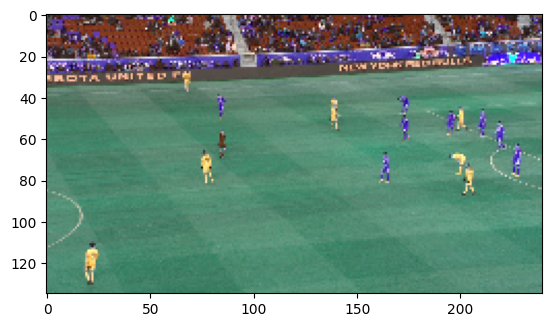

In [41]:
def load_images(folder,max_images=MAX_IMAGES):
    images = {}
    
    for idx, filename in enumerate(sorted(os.listdir(folder))):
        if idx >= max_images:
            break
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is None:
            continue
        images[filename] = img
    return images




og_images_dict = load_images(IMAGE_FOLDER)

resized_images_dict = {key: cv2.resize(value, NEW_SIZE) for key,value in og_images_dict.items()}

# normalized images
normalized_images_dict = {key: value/255.0 for key,value in resized_images_dict.items()}
print(f"{len(normalized_images_dict)} images loaded with size {list(normalized_images_dict.values())[TEST_INDX].shape}")
filenames = list(normalized_images_dict.keys())
plt.imshow(normalized_images_dict[filenames[TEST_INDX]])
plt.show()



#computed grayscale just in case
gray = np.dot(np.array(list(normalized_images_dict.values())), [0.2989, 0.5870, 0.1140])[..., np.newaxis]




### **<span style="color:rgb(124, 252, 0);">Loading annotations</span>**

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
image details json example: {'id': 1, 'width': 1920, 'height': 1080, 'file_name': '0.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}
category json example: {'id': 1, 'name': 'person', 'supercategory': ''}
annotation json example: {'id': 1, 'image_id': 1, 'category_id': 1, 'segmentation': [[1630.5, 686.9, 1632.0, 683.6, 1633.4, 679.7, 1634.2, 676.1, 1634.2, 673.0, 1634.8, 669.8, 1634.8, 667.5, 1636.7, 665.0, 1637.6, 664.8, 1638.0, 665.9, 1639.1, 669.3, 1641.2, 673.4, 1643.5, 678.4, 1645.4, 682.1, 1648.1, 686.4, 1650.2, 688.8, 1650.9, 691.6, 1650.0, 693.9, 1647.4, 695.9, 1644.6, 697.6, 1643.9, 699.1, 1646.1, 700.1, 1650.6, 700.0, 1655.2, 699.9, 1658.5, 699.5, 1661.6, 698.5, 1662.1, 697.2, 1661.5, 694.9, 1660.7, 693.0, 1659.9, 691.7, 1659.1, 689.6, 1658.3, 687.1, 1657.1, 685.2, 1656.1, 683.1, 1654.8, 680.1, 1653.8, 676.5, 1652.6, 672.3, 1650.5, 669.2, 1649.1, 667.3, 1648.2, 664.9, 

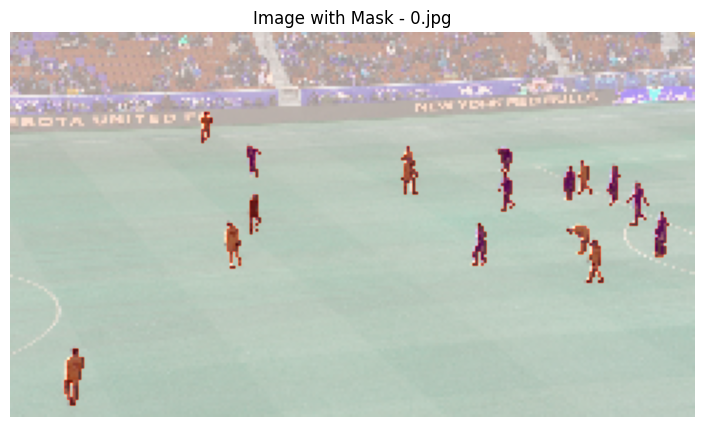

In [42]:
coco = COCO(os.path.join(ANNOTATION_FOLDER,"instances_default.json"))
print("image details json example:",coco.dataset["images"][0])
print("category json example:",coco.dataset["categories"][0])
print("annotation json example:",coco.dataset["annotations"][0])

filename_to_id = {img["file_name"]: img["id"] for img in coco.dataset["images"]}

masks = []
filenames = list(normalized_images_dict.keys())

for filename in filenames:
    image_id = filename_to_id.get(filename)
    if image_id is None:
        mask = np.zeros((IMAGE_SIZE[1], IMAGE_SIZE[0]), dtype=np.uint8)
    else:
        ann_ids = coco.getAnnIds(imgIds=image_id, catIds=[CATEGORY_ID])
        anns = coco.loadAnns(ann_ids)

        mask = np.zeros((IMAGE_SIZE[1], IMAGE_SIZE[0]), dtype=np.uint8)
        for ann in anns:
            mask += coco.annToMask(ann)

        mask = np.clip(mask, 0, 1)
    downscaled_shape = (IMAGE_SIZE[0] // RATIO, IMAGE_SIZE[1] // RATIO)
    mask_resized = cv2.resize(mask, downscaled_shape, interpolation=cv2.INTER_NEAREST)
    masks.append(mask_resized)



test_img_norm= list(normalized_images_dict.values())[TEST_INDX]

og_test_img= list(og_images_dict.values())[TEST_INDX]


mask = masks[TEST_INDX]


plt.figure(figsize=(10, 5))
plt.imshow(test_img_norm)
plt.imshow(mask, cmap="Reds", alpha=0.6)
plt.title(f"Image with Mask - {filenames[TEST_INDX]}")
plt.axis('off')
plt.show()

## **<span style="color:rgb(34, 139, 34);">Creating Features </span>**

### **<span style="color:rgb(124, 252, 0);">Position of the picture</span>**
- position of each pixel was calculated and stacked onto third channel, meaning the third channel is now r,g,b,x,y

In [43]:
def pos_extract(img):
    x_coords = np.tile(np.arange(H), (W, 1))  
    y_coords = np.tile(np.arange(W).reshape(-1, 1), (1, H))  
    norm_x_coords=x_coords/H
    norm_y_coords=y_coords/W
    img=np.dstack([img,norm_x_coords,norm_y_coords])
    return img


pos_extracted_imgs_dict={key: pos_extract(value) for key,value in normalized_images_dict.items()}


### **<span style="color:rgb(124, 252, 0);">Edge detection</span>**
- different methods of edge detection were used and the best one was stacked onto third channel.

#### **<span style="color:rgb(152, 255, 152);">Sobel,Prewitt and Roberts operators</span>**
These edge detection operators are commonly used in image processing to detect edges in images.

1. **Sobel Operator**<br>
The Sobel operator uses two 3x3 kernels to detect horizontal and vertical edges.

$$
\begin{bmatrix}
-1 & -2 & -1 \\
0  &  0   &  0  \\
1  &  2   &  1  
\end{bmatrix} 
\quad
\begin{bmatrix}
-1 &  0 &  1 \\
-2 &  0 &  2 \\
-1 &  0 &  1 
\end{bmatrix}
$$

2. **Prewitt Operator**<br>
The Prewitt operator uses two 3x3 kernels similar to the Sobel operator.


$$
\begin{bmatrix}
-1 &  0 &  1 \\
-1 &  0 &  1 \\
-1 &  0 &  1 
\end{bmatrix} \quad
\begin{bmatrix}
1  &  0 & -1 \\
1  &  0 & -1 \\
1  &  0 & -1 
\end{bmatrix}
$$






3. **Roberts Operator**<br>
The Roberts operator uses two 2x2 kernels.

$$
\begin{bmatrix}
-1 &  0 \\
0  &  1 
\end{bmatrix} \quad
\begin{bmatrix}
1  &  0 \\
0  & -1 
\end{bmatrix}
$$



In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sobel_operator(image_norm):
    
    if image_norm.dtype == np.float32 or image_norm.max() <= 1.0:
        image = (image_norm * 255).astype(np.uint8)
    image=image[:,:,:3]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)

    edge = np.sqrt(sobel_x**2 + sobel_y**2)

    return np.uint8(edge)


def prewitt_operator(image_norm):
    if image_norm.dtype == np.float32 or image_norm.max() <= 1.0:
        image = (image_norm * 255).astype(np.uint8)
    else:
        image = image_norm

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)

    kernel_x = np.array([[-1, 0, 1],
                         [-1, 0, 1],
                         [-1, 0, 1]], dtype=np.float32)
    
    kernel_y = np.array([[1, 1, 1],
                         [0, 0, 0],
                         [-1, -1, -1]], dtype=np.float32)

    gx = cv2.filter2D(gray, -1, kernel_x)
    gy = cv2.filter2D(gray, -1, kernel_y)

    edge = np.sqrt(gx**2 + gy**2)
    edge = cv2.normalize(edge, None, 0, 255, cv2.NORM_MINMAX)
    return np.uint8(edge)

def roberts_operator(image_norm):
    if image_norm.dtype == np.float32 or image_norm.max() <= 1.0:
        image = (image_norm * 255).astype(np.uint8)
    else:
        image = image_norm

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)

    kernel_x = np.array([[1, 0], [0, -1]], dtype=np.float32)
    kernel_y = np.array([[0, 1], [-1, 0]], dtype=np.float32)

    gx = cv2.filter2D(gray, -1, kernel_x)
    gy = cv2.filter2D(gray, -1, kernel_y)

    edge = np.sqrt(gx**2 + gy**2)
    edge = cv2.normalize(edge, None, 0, 255, cv2.NORM_MINMAX)
    return np.uint8(edge)




#### **<span style="color:rgb(152, 255, 152);">Canny Operator</span>**

The Canny operator is a multi-step edge detection algorithm developed by John F. Canny in 1986. It is considered one of the most accurate and robust methods for detecting edges in images.

#### Steps of the Canny Operator:

1. **Noise Reduction** (Gaussian Filtering)<br>

* The image is smoothed using a Gaussian filter to reduce noise.
* This step helps to remove random variations in pixel intensity caused by sensor noise, digitization errors, etc.
* A typical Gaussian filter used for noise reduction has a kernel of the form:

$$
\begin{bmatrix} 0.0625 & 0.1250 & 0.0625 \\ 0.1250 & 0.2500 & 0.1250 \\ 0.0625 & 0.1250 & 0.0625 \end{bmatrix}
$$

* The filter size and standard deviation can be adjusted depending on the image characteristics.
2. **Gradient Calculation**<br>

* The gradient of each pixel is calculated using the Sobel or Laplacian operator.
* This step helps to measure the intensity changes across different directions in the image.
* A typical Sobel kernel for edge detection has a form:

$$
\begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix} \quad \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}
$$

* The Laplacian of Gaussian (LoG) operator can also be used for gradient calculation.

3. **Non-Maximum Suppression**<br>

* Only pixels with maximum intensity values in their respective neighborhoods are considered as edges.
* This step helps to reduce the number of edge points by identifying the most significant ones.
* A typical non-maximum suppression kernel has a form:

$$
\begin{bmatrix} -1 & 0 & 1 \\ -1 & 0 & 1 \\ -1 & 0 & 1 \end{bmatrix} \quad \begin{bmatrix} 1 & 0 & -1 \\ 1 & 0 & -1 \\ 1 & 0 & -1 \end{bmatrix}
$$

* The kernel size and shape can be adjusted depending on the image characteristics.

4. **Double Thresholding**<br>

* Edges are thresholded twice: a low threshold for weak edges and a high threshold for strong edges.
* This step helps to eliminate noise and false positives while retaining significant edges.
* A typical double thresholding scheme has two thresholds:
	+ Low threshold (T1): weak edges with intensity values below T1 are discarded
	+ High threshold (T2): strong edges with intensity values above T2 are retained

5. **Edge Tracking by Hysteresis**<br>

* Weaker edges that are connected to stronger edges are also considered as edges.
* This step helps to connect fragmented edges while avoiding noise and false positives.
* A typical hysteresis threshold (T3) is used to determine the minimum intensity value required for an edge point to be accepted

The Canny operator's output is a binary image where pixels with values of 1 represent edge points, and pixels with values of 0 represent non-edge points.

In [45]:
def canny_operator(image_norm, thres1=THRESHOLD1, thres=THRESHOLD2):
    if image_norm.dtype == np.float32 or image_norm.max() <= 1.0:
        image = (image_norm * 255).astype(np.uint8)
    else:
        image = image_norm
    image=image[:,:,:3]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edge = cv2.Canny(image_gray, threshold1=thres1, threshold2=thres)
    return edge



#### **<span style="color:rgb(152, 255, 152);">Laplacian of Gaussian and Difference of Gaussian Operators</span>**
**LoG Operator**<br>

* Computes the second derivative of a Gaussian filter to detect edges
* The LoG kernel is given by:

$$\frac{\partial^2}{\partial x^2} G(x, \sigma) = -\frac{1}{\sigma^4} e^{-x^2 / (2\sigma^2)}
$$
**DoG Operator**<br>

* Computes the difference between two Gaussian filters with different standard deviations
* The DoG kernel is given by:
$$
D(x, \sigma_1, \sigma_2) = G(x, \sigma_1) - G(x, \sigma_2)$$
Both LoG and DoG operators are used for edge detection, but DoG operator is more computationally efficient. However, LoG operator can detect edges with high accuracy, especially in noisy images.

In [46]:
def log_operator(image_norm, ksize=5, sigma=1.0):
    if image_norm.dtype == np.float32 or image_norm.max() <= 1.0:
        image = (image_norm * 255).astype(np.uint8)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (ksize, ksize), sigmaX=sigma)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
    edge = np.absolute(laplacian)
    edge = cv2.normalize(edge, None, 0, 255, cv2.NORM_MINMAX)
    return edge.astype(np.uint8)

def dog_operator(image_norm, sigma1=1.0, sigma2=2.0):
    if image_norm.dtype == np.float32 or image_norm.max() <= 1.0:
        image = (image_norm * 255).astype(np.uint8)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)

    blur1 = cv2.GaussianBlur(gray, (0, 0), sigmaX=sigma1)
    blur2 = cv2.GaussianBlur(gray, (0, 0), sigmaX=sigma2)

    dog = blur1 - blur2

    dog = np.abs(dog)
    dog = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX)
    return dog.astype(np.uint8)


#### **<span style="color:rgb(152, 255, 152);">Comparsion</span>**

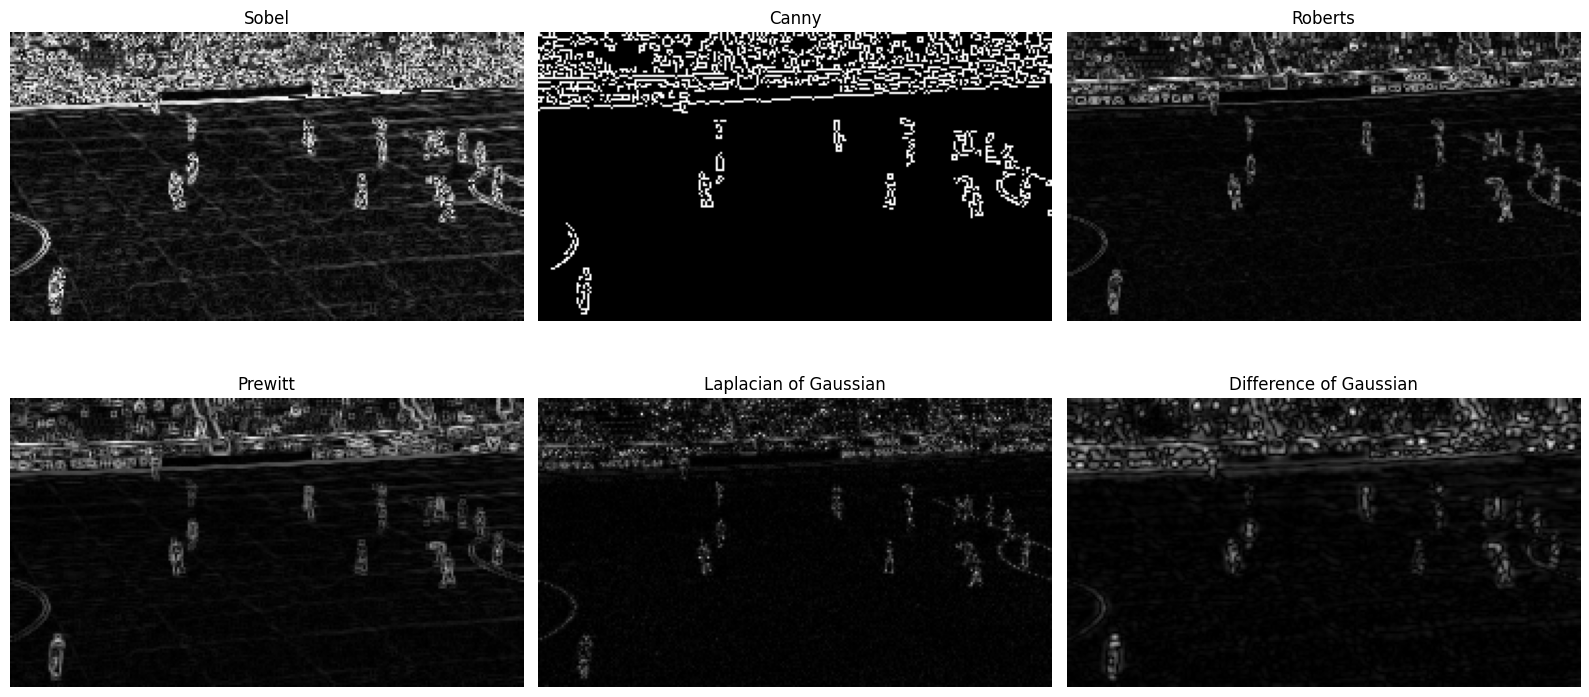

(97200, 6)

In [47]:
test_img_rgb = test_img_norm[:, :, :3]

sobel_example = sobel_operator(test_img_rgb)
canny_example = canny_operator(test_img_rgb)
roberts_example = roberts_operator(test_img_rgb)
prewitt_example = prewitt_operator(test_img_rgb)
log_example=log_operator(test_img_rgb,3,0.5)
dog_example=dog_operator(test_img_rgb)

plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.imshow(sobel_example, cmap='gray')
plt.title("Sobel")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(canny_example, cmap='gray')
plt.title("Canny")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(roberts_example, cmap='gray')
plt.title("Roberts")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(prewitt_example, cmap='gray')
plt.title("Prewitt")
plt.axis('off')



plt.subplot(2, 3, 5)
plt.imshow(log_example, cmap='gray')
plt.title("Laplacian of Gaussian")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(dog_example, cmap='gray')
plt.title("Difference of Gaussian")
plt.axis('off')



plt.tight_layout()
plt.show()


def edge_feature_extract(img, method=SOBEL):
    img_rgb = img[:, :, :3]
    pos_x = img[:, :, 3:4]
    pos_y = img[:, :, 4:5]

    if method == SOBEL:
        edge = sobel_operator(img_rgb)
    elif method == CANNY:
        edge = canny_operator(img_rgb)
    elif method == ROBERTS:
        edge = roberts_operator(img_rgb)
    elif method == PREWITT:
        edge = prewitt_operator(img_rgb)
    elif method == LOG:
        edge = log_operator(img_rgb)
    elif method == DOG:
        edge = dog_operator(img_rgb)
    else:
        raise ValueError(f"Unknown method: {method}")

    edge = edge.astype(np.float32) / 255.0
    edge = edge[..., np.newaxis]

    return np.concatenate([img_rgb.astype(np.float32), pos_x, pos_y, edge], axis=2)


edge_imgs_dict={key: edge_feature_extract(value,EDGE_METHOD) for key,value in pos_extracted_imgs_dict.items()}
imga=np.array(list(edge_imgs_dict.values())).reshape(-1,6)
imga.shape


### **<span style="color:rgb(124, 252, 0);">Texture detection</span>**

#### **<span style="color:rgb(152, 255, 152);">Local Binary Pattern</span>**
The Local Binary Pattern (LBP) is a texture analysis operator that labels the pixels of an image based on their local neighborhood. It is widely used in computer vision and pattern recognition tasks.
**How LBP Works:**<br>

1. Divide the image into small regions or blocks.
2. For each block, calculate the LBP code by comparing the pixel values with its neighboring pixels.
3. The LBP code is a binary string that represents the local texture pattern of the block.
4. Use the LBP codes to build histograms that represent the distribution of textures in the image.

**note:** use this section with caution, i was new to lbp and have very basic understanding of it

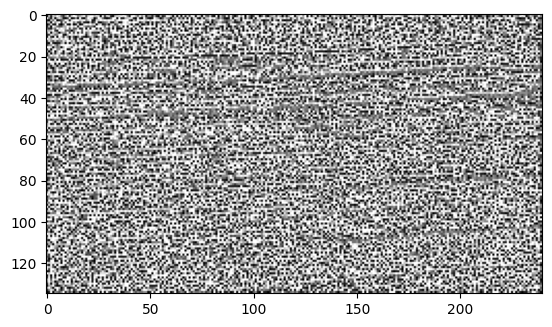

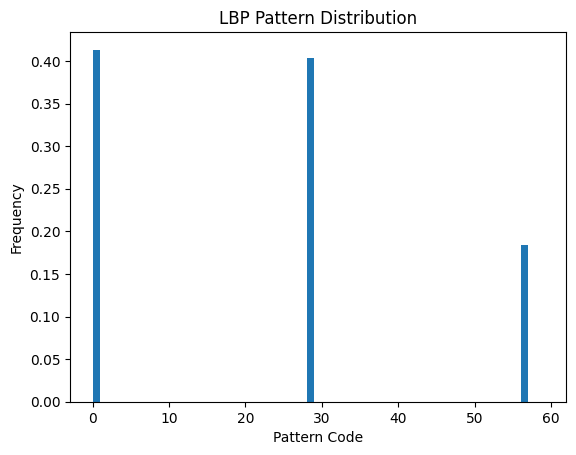

(97200, 7)


In [48]:


def lbp_operator(image_norm, radius=1, n_points=8):
    if image_norm.dtype == np.float32 or image_norm.max() <= 1.0:
        image = (image_norm * 255).astype(np.uint8)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    lbp = cv2.normalize(lbp, None, 0, 255, cv2.NORM_MINMAX)
    return lbp.astype(np.uint8)


lbp_example=lbp_operator(test_img_rgb)
plt.imshow(lbp_example,cmap="gray")
plt.show()

plt.hist(lbp_example.ravel(), bins=np.arange(60), density=True)
plt.title("LBP Pattern Distribution")
plt.xlabel("Pattern Code")
plt.ylabel("Frequency")
plt.show()

def texture_feature_extract(img):
    img_rgb = img[:, :, :3]
    pos_x = img[:, :, 3:4]
    pos_y = img[:, :, 4:5]
    edge = img[:, :, 5:6]

    texture = lbp_operator(img_rgb).astype(np.float32) / 255.0
    texture = texture[..., np.newaxis]  

    return np.concatenate([
        img_rgb.astype(np.float32),
        pos_x,
        pos_y,
        edge.astype(np.float32),
        texture
    ], axis=2)

features_dict={key: texture_feature_extract(value) for key,value in edge_imgs_dict.items()}


feature_vectors=np.array(list(features_dict.values())).reshape(-1,7)
print(feature_vectors.shape)


## **<span style="color:rgb(34, 139, 34);">Cluster pixels </span>**


### **<span style="color:rgb(124, 252, 0);">K-means</span>**

#### **<span style="color:rgb(152, 255, 152);">Inertia</span>**:
inertia can be used to evaluate the clustring and find a good k using elbow method

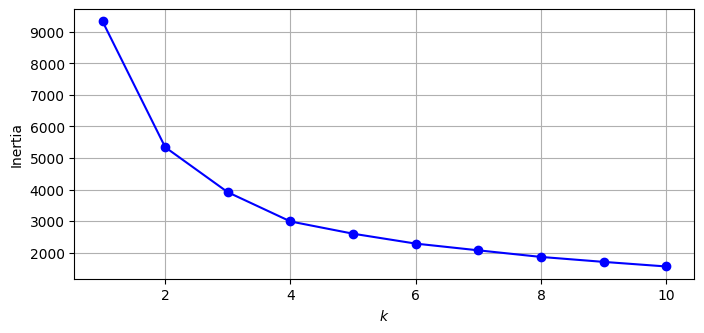

In [49]:

max_k=10
features_k_means = feature_vectors[..., [i for i in range(feature_vectors.shape[-1]) if i not in [3,4,6]]]
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(features_k_means)
                for k in range(1, max_k+1)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_k+1), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.grid()
plt.show()


#### **<span style="color:rgb(152, 255, 152);">Silhoutte Score</span>**

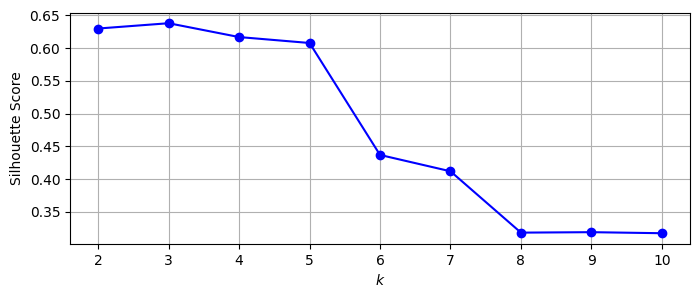

In [50]:
# calculating the silhoutte score for the whole feature vector will take too long so we took a sample from it
subset_idx = np.random.choice(feature_vectors.shape[0], min(10000,len(feature_vectors)), replace=False)
features_subset = features_k_means[subset_idx]

silhouette_scores = []

for model in kmeans_per_k[1:]:
    labels_subset = model.predict(features_subset)
    score = silhouette_score(features_subset, labels_subset)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 3))
plt.plot(range(2, max_k+1), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()


#### **<span style="color:rgb(152, 255, 152);">Result</span>**

(3, 135, 240)


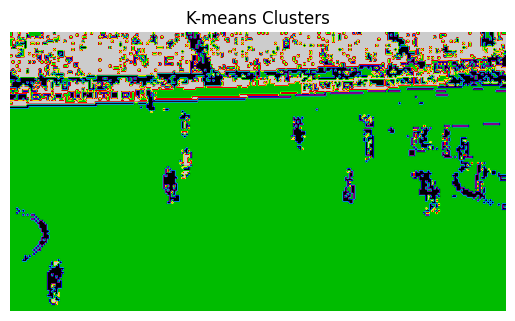

In [51]:
k=3
kmeans_labels_img = kmeans_per_k[k-1].labels_.reshape(MAX_IMAGES, W, H)
k_mean_labels=kmeans_per_k[k-1].labels_
print(kmeans_labels_img.shape)
plt.imshow(test_img_norm)
plt.imshow(kmeans_labels_img[TEST_INDX], alpha=1,cmap="nipy_spectral")
plt.title("K-means Clusters")
plt.axis('off')
plt.show()



### **<span style="color:rgb(124, 252, 0);">HDBSCAN</span>**

Found 25 clusters
Noise points: 22245


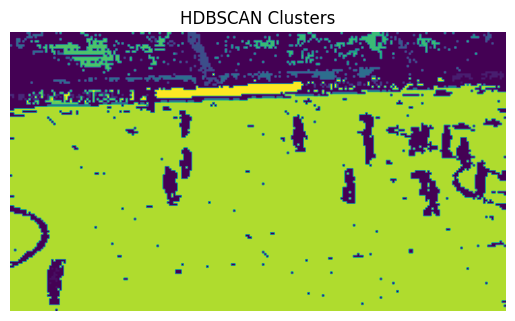

In [52]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import hdbscan

#exclude unnecessary features
features_hdbscan = feature_vectors[..., [i for i in range(feature_vectors.shape[-1]) if i not in [6]]]

clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
hdbscan_labels = clusterer.fit_predict(features_hdbscan)
hdbscan_labels_img = hdbscan_labels.reshape(MAX_IMAGES,W,H)
print(f"Found {len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)} clusters")
print(f"Noise points: {(hdbscan_labels == -1).sum()}")
plt.imshow(test_img_norm)
plt.imshow(hdbscan_labels_img[TEST_INDX],alpha=1) 
plt.axis('off')
plt.title("HDBSCAN Clusters")
plt.show()




### **<span style="color:rgb(124, 252, 0);">DBSCAN</span>**
**Why Does DBSCAN Assign `-1` Labels to Player Pixels?**

DBSCAN works by grouping together points that are densely packed in feature space, while labeling points that lie alone in low-density regions as noise (`-1` label).

In our task, after extracting rich features from the image using a pretrained model like HRNet or ResNet, player pixels tend to have feature representations that differ significantly from the background (field, crowd, etc.). Because players are often visually distinct and occupy relatively small, isolated regions compared to the larger, more homogeneous background:

* **Players form sparse clusters** in the feature space due to their unique appearance.
* **DBSCAN identifies these sparse player pixels as noise** (label `-1`) because they do not belong to any high-density cluster of the background or crowd.
* This behavior actually helps **separate player pixels from the background**, effectively marking them as outliers or "interesting" points.

Therefore, tuning DBSCAN parameters (like `eps` and `min_samples`) allows us to isolate players by labeling their pixels as `-1`, which corresponds to noise or outliers in DBSCAN terminology but in this context helps segment the players.

(97200, 6)
Clusters found: 31
Noise points: 8972


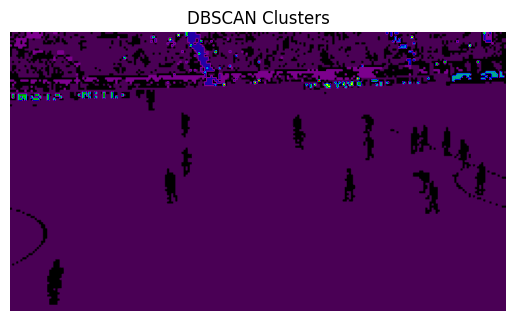

In [53]:
def apply_dbscan(features_dbscan,epsilon=0.1,min_samples=10):
    dbscan = DBSCAN(eps=epsilon,min_samples=min_samples, n_jobs=-1)
    labels = dbscan.fit_predict(features_dbscan)

    print(f"Clusters found: {len(set(labels)) - (1 if -1 in labels else 0)}")
    print(f"Noise points: {(labels == -1).sum()}")
    return labels





features_dbscan =  feature_vectors[..., [i for i in range(feature_vectors.shape[-1]) if i not in [6]]]
print(features_dbscan.shape)
dbscan_labels=apply_dbscan(features_dbscan,0.1,2*len(features_dbscan[0])) 
dbscan_labels_img = dbscan_labels.reshape(MAX_IMAGES, W, H)
plt.imshow(test_img_norm)
plt.imshow(dbscan_labels_img[TEST_INDX], alpha=1,cmap="nipy_spectral")
plt.axis('off')
plt.title("DBSCAN Clusters")
plt.show()


## **<span style="color:rgb(34, 139, 34);"> Filtering,Merging and Even More Clustering! </span>**


### **<span style="color:rgb(124, 252, 0);">Filtering</span>**
- clusters too small or too big were changed to 0(background)

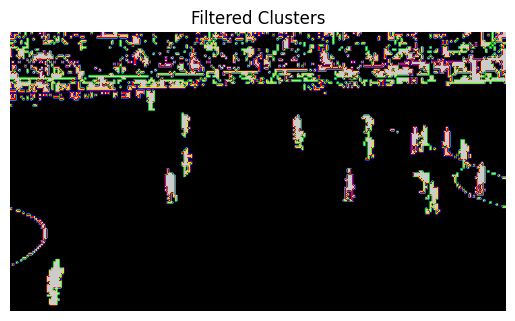

In [54]:
def find_cluster_sizes(labels_flatten):
    replaced_value=max(labels_flatten)+1 
    labels_flatten = [replaced_value if i == -1 else i for i in labels_flatten]
    cluster_sizes = np.bincount(labels_flatten)
    # print(cluster_sizes)
    return cluster_sizes,labels_flatten

def filter_cluster(cluster_sizes,minthresh=MAX_IMAGES*600,maxthresh=MAX_IMAGES*10000):
    valid_clusters=[]
    for i,cluster_size in enumerate(cluster_sizes):
        if minthresh<cluster_size<maxthresh:
            valid_clusters.append(i)
    return valid_clusters


cluster_sizes,labels=find_cluster_sizes(dbscan_labels)
valid_clusters=filter_cluster(cluster_sizes)
filtered_labels_flatten=np.array([i if i in valid_clusters else 0 for i in labels])
filtered_labels_img=filtered_labels_flatten.reshape(MAX_IMAGES,W,H)
plt.imshow(filtered_labels_img[TEST_INDX], alpha=1,cmap="nipy_spectral")
plt.axis('off')
plt.title("Filtered Clusters")
plt.show()


### **<span style="color:rgb(124, 252, 0);">Merging and Re-clustring:</span>**
1. diltation was used to thicken the boudaries of clusters.
2. cv2's premade function was used to find the connected components basically doing an small clustring 

In [55]:
import cv2

def merge_close_clusters(label_img, min_area=30, dilation_iter=1):
    new_img = np.zeros_like(label_img)
    binary_mask = np.zeros_like(label_img)
    centroids_list = []
    current_label = 1
    unique_labels = np.unique(label_img)

    for lbl in unique_labels:
        if lbl == 0:
            continue
        mask = (label_img == lbl).astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        dilated = cv2.dilate(mask, kernel, iterations=dilation_iter)

        num_labels, conn_labels, stats, centroids = cv2.connectedComponentsWithStats(dilated)
        for i in range(1, num_labels):
            width = stats[i, cv2.CC_STAT_WIDTH]
            height = stats[i, cv2.CC_STAT_HEIGHT]
            h_w_ratio = height / (width + 1e-5)
            area = stats[i, cv2.CC_STAT_AREA]
            if 1 < h_w_ratio < 5 and area >= min_area:
                new_img[conn_labels == i] = current_label
                binary_mask[conn_labels == i] = 1
                centroids_list.append(centroids[i])
                current_label += 1

    return new_img, binary_mask, np.array(centroids_list)


def apply_merge(filtered_img):
    merged = []
    binary_masks = []
    centroid_coords = []

    for lbl_img in filtered_img:
        m, b, c = merge_close_clusters(lbl_img)
        merged.append(m)
        binary_masks.append(b)
        centroid_coords.append(c)

    merged = np.array(merged)
    binary_masks = np.array(binary_masks)
    return merged,binary_masks,centroid_coords

merged,binary_masks,centroid_coords=apply_merge(filtered_labels_img)


output of connectedComponentsWithStats was used to make a new image with new clusters

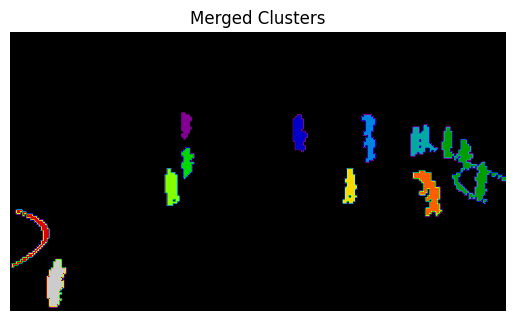

In [56]:
plt.imshow(merged[TEST_INDX], cmap='nipy_spectral')
plt.axis('off')
plt.title("Merged Clusters")
plt.show()

centroids of clusters made above are marked as red in the image below.

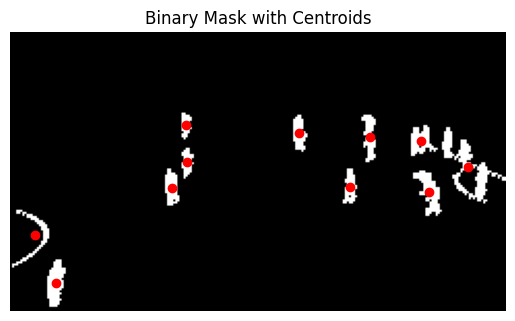

In [57]:
plt.imshow(binary_masks[TEST_INDX], cmap='gray')
for (x, y) in centroid_coords[TEST_INDX]:
    plt.plot(x, y, 'ro', markersize=6)
plt.axis('off')
plt.title("Binary Mask with Centroids")
plt.show()



## **<span style="color:rgb(34, 139, 34);">More Advanced Features! </span>**

### **<span style="color:rgb(124, 252, 0);">Creating Features:</span>**
HRNet model was used to extract feature_vectors instead of manual extraction in the first part. 

In [58]:
import torch
import numpy as np
import cv2
import timm
import torch.nn.functional as F
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from PIL import Image


def get_feature_model(mode=CNN_MODE ):
    if mode == "hrnet":
        model = timm.create_model('hrnet_w18', pretrained=True, features_only=True)
    elif mode == "resnet":
        model = timm.create_model('resnet50', pretrained=True, features_only=True)
    else:
        raise ValueError("Invalid mode. Choose 'hrnet' or 'resnet'.")
    model.eval()
    return model


# timm messes up the dimension of the image a little
def transformer(img, model, mode="normal"):
    if mode == "normal":
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        img_norm = cv2.resize(img / 255.0, (224, 224))
        tensor_img_norm = torch.tensor(img_norm, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
        tensor_img_norm = (tensor_img_norm - mean) / std
        return tensor_img_norm.squeeze(0)
    elif mode == "timm":
        config = resolve_data_config({}, model=model)
        transform = create_transform(**config)
        img_uint8 = img.astype(np.uint8) if img.dtype != np.uint8 else img
        img_pil = Image.fromarray(img_uint8)
        img_t = transform(img_pil)
        return img_t
    else:
        raise ValueError("Mode must be 'normal' or 'timm'")




def extract_cnn_features(og_images_dict, mode=CNN_MODE, transformer_mode="normal"):
    model = get_feature_model(mode)
    tensor_imgs_norm = torch.stack([transformer(img, model, mode=transformer_mode) for img in og_images_dict.values()])
    print(f"Image tensor shape: {tensor_imgs_norm.shape}")  # (B, C, H, W)

    with torch.no_grad():
        cnn_features_batch = model(tensor_imgs_norm)[0]  # (B, C, h, w)

    print(f"Feature map shape: {cnn_features_batch.shape}")

    feats_up_batch = F.interpolate(cnn_features_batch, size=(W, H), mode='bilinear', align_corners=False)
    features_cnn_up_batch = feats_up_batch.permute(0, 2, 3, 1).cpu().numpy()  # (B, W, H, C)
    print(f"Upsampled feature batch shape: {features_cnn_up_batch.shape}")

    # Add position
    features_cnn_up_batch = np.array([pos_extract(img) for img in features_cnn_up_batch])

    # Flatten for clustering
    cnn_features_flattened = features_cnn_up_batch.reshape(-1, features_cnn_up_batch.shape[-1])
    return cnn_features_flattened


cnn_features_flattened = extract_cnn_features(og_images_dict)


Unexpected keys (downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.num_batches_tracked, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.num_batches_tracked, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.num_batches_tracked, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Image tensor shape: torch.Size([3, 3, 224, 224])
Feature map shape: torch.Size([3, 64, 112, 112])
Upsampled feature batch shape: (3, 135, 240, 64)



### **<span style="color:rgb(124, 252, 0);">PCA Dimension Reduction</span>**
PCA is used to reduce the dimensions of the array

In [59]:

pca = PCA(n_components=0.95)
pca_features= pca.fit_transform(cnn_features_flattened)
print(f"The number of dimensions before reduction: {cnn_features_flattened.shape[1]}.")
print(f"The number of dimensions after reduction: {pca.n_components_}.")
print(pca_features.shape)


The number of dimensions before reduction: 66.
The number of dimensions after reduction: 12.
(97200, 12)


rest of this part(more advanced figure) is basically the same as we did in the filtering and merging part 


### **<span style="color:rgb(124, 252, 0);">DBSCAN</span>**

Clusters found: 10
Noise points: 15145


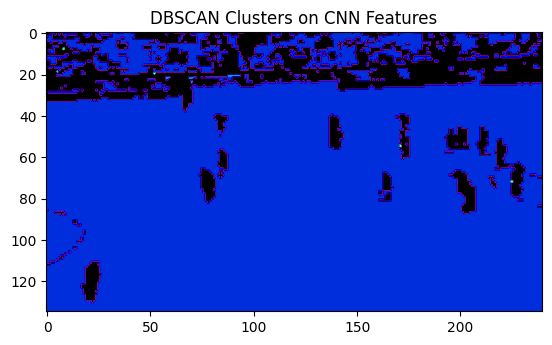

In [60]:
cnn_labels=apply_dbscan(pca_features,0.4)
# hrnet: eps=0.3 , resnet: 1.3
cnn_labels_imgs = cnn_labels.reshape(MAX_IMAGES,W, H)
plt.imshow(test_img_norm)
plt.imshow(cnn_labels_imgs[TEST_INDX], alpha=1,cmap="nipy_spectral")
plt.axis('on')
plt.title("DBSCAN Clusters on CNN Features")
plt.show()




### **<span style="color:rgb(124, 252, 0);">Filtering</span>**

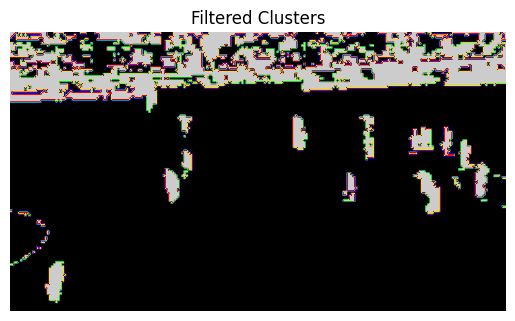

In [61]:
cnn_cluster_sizes, cnn_labels= find_cluster_sizes(cnn_labels)

valid_clusters = filter_cluster(cnn_cluster_sizes)
cnn_filtered_labels_flatten = np.array([label if label in valid_clusters else 0 for label in cnn_labels])

cnn_filtered_labels_imgs = cnn_filtered_labels_flatten.reshape(MAX_IMAGES, W, H)

plt.imshow(test_img_norm)
plt.imshow(cnn_filtered_labels_imgs[TEST_INDX], alpha=1, cmap="nipy_spectral")
plt.axis('off')
plt.title("Filtered Clusters")
plt.show()



### **<span style="color:rgb(124, 252, 0);">Merging and Re-clustring:</span>**

In [62]:

cnn_merged,cnn_binary_masks,cnn_centroid_coords=apply_merge(cnn_filtered_labels_imgs)

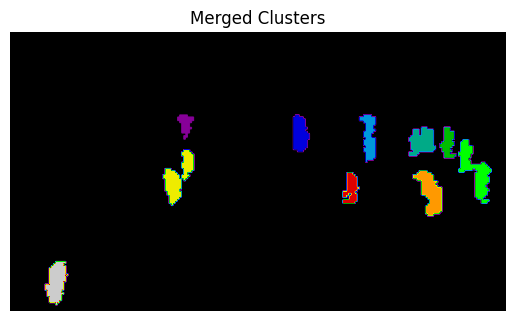

In [63]:
plt.imshow(cnn_merged[TEST_INDX], cmap='nipy_spectral')
plt.axis('off')
plt.title("Merged Clusters")
plt.show()

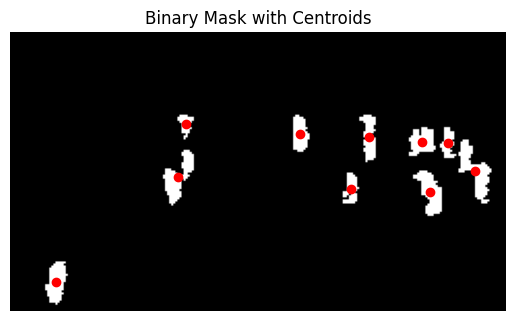

In [64]:
plt.imshow(cnn_binary_masks[TEST_INDX], cmap='gray')
for (x, y) in cnn_centroid_coords[TEST_INDX]:
    plt.plot(x, y, 'ro', markersize=6)
plt.axis('off')
plt.title("Binary Mask with Centroids")
plt.show()


## **<span style="color:rgb(34, 139, 34);">Evaluation</span>**

CNN Binary Masks - Dice: 0.6221, IoU: 0.4517
Other Binary Masks - Dice: 0.6667, IoU: 0.5002


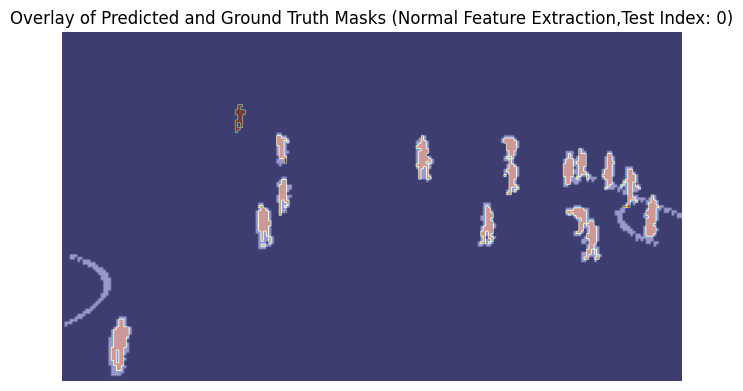

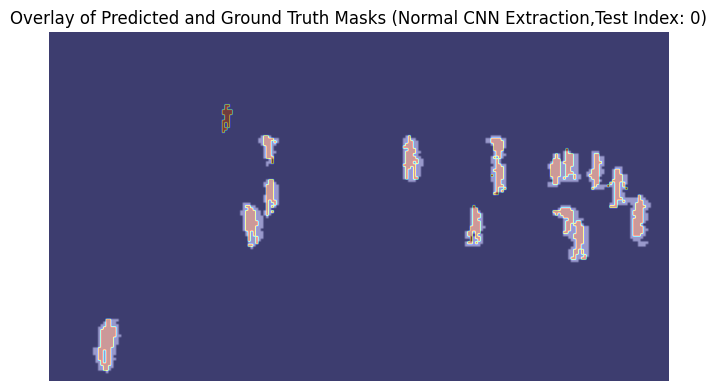

In [65]:
import numpy as np

def compute_dice_and_iou(pred_mask, gt_mask):
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)
    
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    dice = (2 * intersection) / (pred_mask.sum() + gt_mask.sum() + 1e-8)
    iou = intersection / (union + 1e-8)
    
    return dice, iou


def evaluate_segmentation(pred_masks, gt_masks):
    dice_scores, iou_scores = [], []
    for pred, gt in zip(pred_masks, gt_masks):
        dice, iou = compute_dice_and_iou(pred, gt)
        dice_scores.append(dice)
        iou_scores.append(iou)
    
    return np.mean(dice_scores), np.mean(iou_scores)



dice_cnn, iou_cnn = evaluate_segmentation(cnn_binary_masks, masks)
print(f"CNN Binary Masks - Dice: {dice_cnn:.4f}, IoU: {iou_cnn:.4f}")

dice_other, iou_other = evaluate_segmentation(binary_masks, masks)
print(f"Other Binary Masks - Dice: {dice_other:.4f}, IoU: {iou_other:.4f}")

# Visualization: overlay predicted mask and ground truth for test index
plt.figure(figsize=(8, 6))
plt.title(f"Overlay of Predicted and Ground Truth Masks (Normal Feature Extraction,Test Index: {TEST_INDX})")
plt.imshow(binary_masks[TEST_INDX], alpha=0.6, cmap='gray')
plt.imshow(masks[TEST_INDX], alpha=0.4, cmap='jet')
plt.axis('off')
plt.show()
plt.figure(figsize=(8, 6))
plt.title(f"Overlay of Predicted and Ground Truth Masks (Normal CNN Extraction,Test Index: {TEST_INDX})")
plt.imshow(cnn_binary_masks[TEST_INDX], alpha=0.6, cmap='gray')
plt.imshow(masks[TEST_INDX], alpha=0.4, cmap='jet')
plt.axis('off')
plt.show()




## **<span style="color:rgb(34, 139, 34);">Questions:</span>**

**Question 1**:

**Provide an example of a segmentation task where each type of segmentation—semantic, instance, and panoptic—is appropriate and sufficient, and explain why each type suits the specific task.**

**✅ Answer:**

* **Semantic Segmentation:**
  *Task:* Satellite imagery analysis to classify land cover types (e.g., forest, water, urban).<br>
  *Why:* We only care about the **type** of region (not individual objects), so all forest pixels are labeled the same, no need to distinguish between individual trees or buildings.

* **Instance Segmentation:**
  *Task:* Counting apples on a tree
  *Why:* You need to detect and distinguish each individual apple, not just label all apple pixels as “apple.” So, different apples get different labels.

* **Panoptic Segmentation:**
  *Task:* Autonomous driving scene understanding.
  *Why:* It combines both semantic (e.g., road, sky, buildings) and instance segmentation (e.g., pedestrians, vehicles) to fully understand the scene. This is necessary for complete environment perception.


**Question 2:**

**Explain the difference between the Dice coefficient and Intersection over Union (IoU) as evaluation metrics in image segmentation. In what scenarios might one be preferred over the other?**

**✅ Answer:**

* **Dice Coefficient (F1 score):**

  $$
  \text{Dice} = \frac{2 \cdot |A \cap B|}{|A| + |B|}
  $$

  It emphasizes **overlap relative to the total size** of the predicted and ground truth masks. It is more forgiving of small segmentation errors.

* **Intersection over Union (IoU):**

  $$
  \text{IoU} = \frac{|A \cap B|}{|A \cup B|}
  $$

  It penalizes **false positives and false negatives** more harshly by comparing intersection over the full union.

* **When to Prefer:**

  * Use **Dice** when the class is **very small** (e.g., medical images with tumors), since it's more sensitive to small overlaps.
  * Use **IoU** when **consistency across all object sizes** is needed (e.g., general object detection).

**Question 3:**

**Imagine a scenario where we need to cluster a large set of images into multiple categories. Methods such as K-means can become computationally expensive and inefficient when applied directly to high-dimensional image data. One approach to address this issue is to use an autoencoder architecture to reduce the dimensionality of the images before clustering. Explain how autoencoders can be used for this purpose. How does this method help improve the efficiency and effectiveness of clustering algorithms like K-means on large image datasets?**

**✅ Answer:**

* **Autoencoders** are neural networks that learn to compress input data into a low-dimensional latent space (encoder), and then reconstruct it (decoder).
* The encoder learns compact **feature representations** that preserve essential structure while reducing noise and dimensionality.

**Steps:**

1. Train an autoencoder on your image dataset.
2. Extract the compressed features from the encoder.
3. Apply **K-means** on these lower-dimensional features instead of raw images.

**Why It Helps:**

* **Efficiency:** Lower dimensional data means **faster clustering** and reduced memory usage.
* **Effectiveness:** The learned features are **more meaningful** than raw pixel values, improving cluster quality.
* Especially useful for high-res images or datasets with complex textures and variations.
